<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Introduction to image similarity

Aside from image classification and object detection, another typical computer vision task is image similarity.

Users who browse a retailer website may indeed be interested in finding pieces of clothing similar to one they like. Some companies may give access to their premises only to people they recognize. Such applications rely on the ability to find images similar to a reference one.

This is usually done by training a siamese network or a triplet loss model. These are advanced techniques, which tend to require a lot of resources and data. In this tutorial, we will start with a simpler method. We will indeed leverage an image classification model, extract vector representations called image embeddings, and compute the distance between them to find the image closest to a reference one.

## Table of Content
1. [Library import](#libraries)
1. [Data preparation](#data-prep)
  1. [Retrieval of the dataset](#retrieval)
  1. [Extraction of test images](#extract-test)
  1. [Creation of the data object](#data-obj)
1. [Training of the classification model](#training)
  1. [Transfer learning](#transfer)
    1. [Model training](#train1)
    1. [Model evaluation](#eval1)
  1. [Training of the entire network](#entire-network)
    1. [Model training](#train2)
    1. [Model evaluation](#eval2)
1. [Performance metrics](#performance)
1. [Next steps](#next)
<br>[Appendix](#appendix)

## 1. Library import <a id="libraries"/>

Let's first load all the libraries we will need to build our model, compute distances, rank our images according to distance and display our results.

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Regular python libraries
import numpy as np
import sys

# fast.ai
import fastai
from fastai.vision import *
from fastai.callbacks.hooks import *

# Other advanced libraries
from operator import itemgetter
from pathlib import Path
from sklearn.neighbors import BallTree
from torch.cuda import get_device_name

# Computer Vision repository
sys.path.extend([".", "../", "../.."])
# This "sys.path.extend()" statement allows us to move up the directory hierarchy 
# and access the utils_cv packages
from utils_cv.classification.data import Urls
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import gpu_info
from utils_cv.similarity.data import comparative_set_builder, SaveFeatures, test_set_extractor
from utils_cv.similarity.metrics import compute_topk_similar, positive_image_median_rank, recall_at_k
from utils_cv.similarity.plot import plot_similars
from utils_cv.similarity.widget import DistanceWidget

In [3]:
print(f"Fast.ai version = {fastai.__version__}")
print(f"Machine's GPU info = {gpu_info()} (memory unit = MiB)")
print(f"Fast.ai/Torch is using {get_device_name(0)}")

Fast.ai version = 1.0.48


## 2. Data preparation <a id="data-prep"/>

Since we are approaching image similarity from an image classification perspective, we will then follow the steps described in the [01_training_introduction.ipynb](../../classification/notebooks/01_training_introduction.ipynb) notebook.

### 2.A Retrieval of the dataset <a id="retrieval"/>

We start with the preparation of our data, and the setting of a few parameters. Here too, we use the *Fridge objects* dataset, which is composed of 134 images, divided into 4 classes: can, carton, milk bottle and water bottle. Images from each of these classes are saved in a separate folder.

In [4]:
# Set dataset, model and evaluation parameters
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS        = 5
IMAGE_SIZE    = 244
LEARNING_RATE = 1e-4
IMAGE_SIZE    = 299
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50
DISTANCE = "l2"
TOP_K = 10

# Extract data path
path = Path(DATA_PATH)

### 2.B Extraction of test images <a id="extract-test"/>

Before starting the training of our model, it is important to isolate a subset of our data, for testing purposes. In our case, we need to extract the same number of images of each class, and remember which class they come from. To make sure that these images are not considered during training, we move them to a `test/` folder, outside of `fridgeObjects/`.

We extract test images this way to allow us to build comparative sets. Each comparative set will be composed of:
- A reference image: image to which the rest of the test images will be compared to find similar images to it
- A positive example: image of the same class as the reference image -- If our model is well trained, we expect the positive example to be the image the most similar to the reference image
- Negative examples: set of images from all the other classes -- We expect these to be "further away" from the reference image than the positive example -- Here, we consider an equal number of images from the "other" classes.

We will use these comparative sets in section [3. Training of the classification model](#training).

In [5]:
# Create a test/ folder outside of fridgeObjects/, so the test images are not considered for training
image_root_folder = os.path.dirname(os.path.dirname(path.ls()[0]))
test_folder = os.path.join(image_root_folder, "test")
os.makedirs(test_folder, exist_ok=True)

# Move images into the test folder
test_set_extractor(path, test_folder, 4)

# Note: If we re-run this cell, the number of images migrated to the test folder will increase, 
# thus making the training set smaller

### 2.C Creation of the data object <a id="data-obj"/>

Now that our test set has been moved out of `fridgeObjects/`, i.e. out of the training folder, we can build our training data object. We can also split it to get a certain percentage (here 20%) assigned to a validation set.

Training set: 95 images
Validation set: 23 images


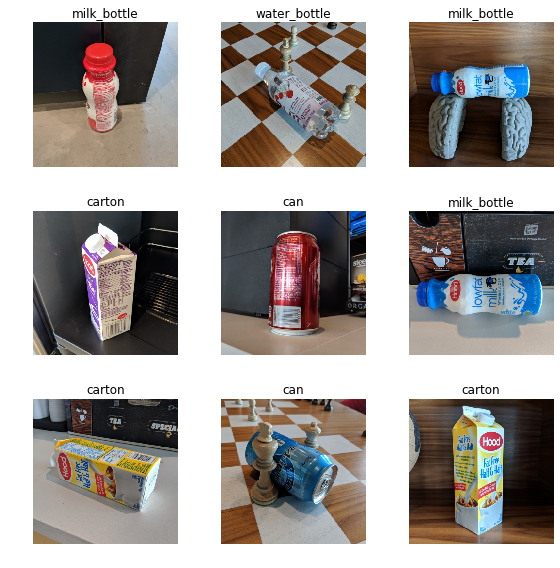

In [6]:
# Load images into fast.ai's ImageDataBunch object
data = (ImageList.from_folder(path) 
        .split_by_rand_pct(valid_pct=0.2, seed=10) 
        .label_from_folder() 
        .transform(size=IMAGE_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))

print(f'Training set: {len(data.train_ds.x)} images\nValidation set: {len(data.valid_ds.x)} images')

# Display example images
data.show_batch(rows=3, figsize=(8,8))

## 3. Training of the classification model <a id="training"/>

In this tutorial, we will use a [ResNet50](https://arxiv.org/pdf/1512.03385.pdf) architecture. We will proceed in 2 steps:
1. Leverage a pre-trained model, and train only its last layer with our own data (i.e. do [transfer learning](https://towardsdatascience.com/transfer-learning-946518f95666))
2. Use the resulting weights and biases as the initialization for a training of the entire network (i.e. unfreeze all layers instead of the last one only).

This 2-step process should give us even better results than with transfer learning only.

We begin by retrieving a pre-trained model from fast.ai's library.

In [7]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)],
    # ps=0.5  # dropout rate
)

Before training it, let's look at its architecture.

In [8]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

Let's, more particularly, focus on the last part. Fast.ai's version of this model is composed of a different set of final layers (cf. `(1): Sequential`). These layers are such that it is easier for us to use this model with [any dataset we want](https://forums.fast.ai/t/fastai-resnet50-final-layers/43496) (and not just ImageNet, which was used to train it).

These layers, especially `(6): BatchNorm1d`, give us access to image features, i.e. to the most important information in a given image. These features are captured in a vector of length 512, in this case. This type of vector is called an image embedding. Such embedding will be the key to compare images, and find similar ones, as we will see below.

For now, let's create an object that will allow us to extract that embedding for any image we will run through the model.

In [9]:
# Extract features from the last batch normalization layer
im_embedding = learn.model[1][6]  ## [1][6] correspond to the indices we discussed above
print(im_embedding)

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### 3.A Transfer learning <a id="transfer"/>

#### 3.A.a Model training <a id="train1"/>

Let's now train the model: first, on the last layer, via transfer learning

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,1.895785,1.290600,0.200000,0.391304,02:53
1,1.792951,1.228955,0.300000,0.434783,02:44
2,1.585721,1.109317,0.487500,0.608696,02:52
3,1.381983,1.038156,0.687500,0.565217,02:59
4,1.242510,0.999278,0.712500,0.521739,02:53


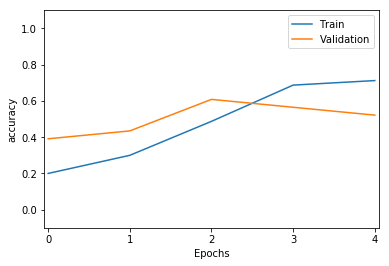

In [10]:
# Train the last layer
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)

#### 3.A.b Model evaluation <a id="eval1"/>

The results we obtained here don't seem very good. Let's see how this translates in terms of image similarity.

For this, we need to:
- save, though the `SaveFeatures()` hook, the features we obtained from the batch normalization layer we referenced above
- run the test data through the model we trained, and get the corresponding predictions using `predict()`
- extract the values of the features we just saved, i.e. the image embeddings we need to find similar images.

The test set we will use here is one of the comparative sets we will generate below with our `comparative_set_builder` function.

In [11]:
# Save the features of the last batch normalization layer
featurizer = SaveFeatures(im_embedding)

In [12]:
# Build multiple sets of comparative images, unseen during training
comparative_sets = comparative_set_builder(Path(test_folder))

The `comparative_sets` object is a dictionary defined as:
- key: reference image path
- value: list of paths of comparative images -- This list is composed of 1 positive and 4 images x 3 classes = 12 negative examples.

`comparative_sets` contains 4 reference images x 4 classes = 16 keys.

In the following cells we will only consider the first key and its associated comparative images.

In [13]:
# Retrieve the first comparative set
first_ref_im_path = list(comparative_sets.keys())[0]
first_comparative_set = comparative_sets[first_ref_im_path]

# Extract the list of paths of images to compare to the first test reference image
im_list = [str(im_path) for im_path in first_comparative_set]
first_comparative_set_paths = [first_ref_im_path] + im_list
print(f"We will compare {first_ref_im_path} to:\n\n{im_list}")

We will compare D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/can__13.jpg to:

['D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/can__22.jpg', 'D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/water_bottle__129.jpg', 'D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/carton__47.jpg', 'D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/water_bottle__105.jpg', 'D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/milk_bottle__101.jpg', 'D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/water_bottle__107.jpg', 'D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/carton__45.jpg', 'D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/milk_bottle__86.jpg', 'D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/milk_bottle__71.jpg', 'D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/carton__43.jpg', 'D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/carton__37.jpg', 'D:/Alteste/Repos2/ComputerVisionBestPractices/data/test/milk_

In [14]:
# Get predictions for the first comparative set
for im_path in first_comparative_set_paths:
    learn.predict(open_image(str(im_path)))

In [15]:
# Retrieve the corresponding image embeddings
features = featurizer.features
print(f"*features* contains {features.shape[0]} embeddings of {features.shape[1]} components each")

*features* contains 14 embeddings of 512 components each


In [16]:
# Associate image path to image embedding
# The resulting dictionary is then used in the following distance computation function (compute_topk_similar)
feature_dict = dict(zip(first_comparative_set_paths, features))

We now have an embedding for each test image of our first comparative set. We can then compute distances between the reference image and the associated positive and negative examples, and rank the latter by increasing distance from the former.

Here, we consider the $L_2$ distance, so we will compute $ \sqrt{\sum_{j=1}^{512}{(emb_{ref}[j] - emb_{im}[j])^{2}}} $, where $emb_{ref}$ is the embedding of the reference image and $emb_{im}$ that of any of the comparative images.

Our `compute_topk_similar()` function can also compute other types of distances, such as L1 and cosine similarity. By default, we choose to normalize our image embeddings before computing the distance between them. This can be changed in the `compute_vector_distance()` sub-function that is available in the same library as `compute_topk_similar()`.

In [17]:
# Compute distances and rank the images by increasing distance from the reference
similars = compute_topk_similar(first_ref_im_path, feature_dict, distance=DISTANCE, top_k=TOP_K+1)

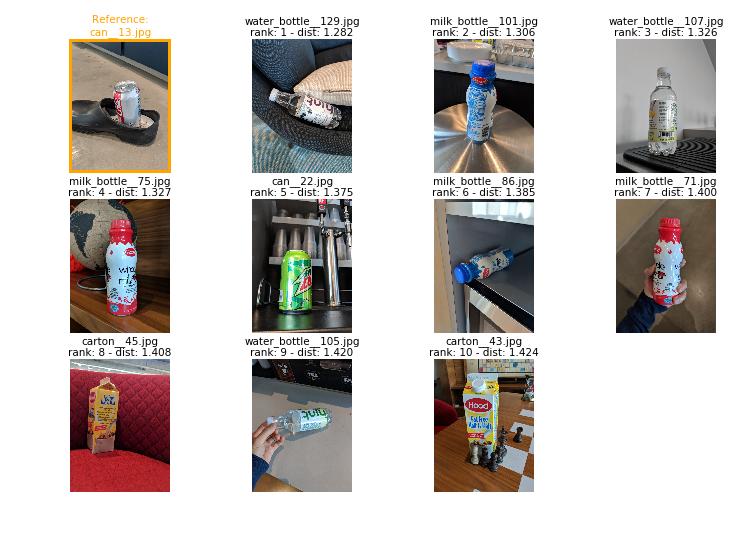

In [31]:
plot_similars(similars, num_rows=3, num_cols=4)

In [19]:
print(f"Embedding of our reference image:\n{features[0,:]}")

Embedding of our reference image:
[ 0.013744 -0.400473 -0.07415  -0.265244 ...  0.771803 -0.050726  0.009937 -0.567038]


As expected, results are rather disappointing. The image truly similar to our reference (in orange frame) is not the closest, i.e. it is not ranked as #1.

### 3.B Training of the entire network <a id="entire-network"/>

To try and make the model better, let's retrain all the network's layers, starting with the weights and biases we obtained from the pre-training and the fine tuning of the last layer. For this, let's "unfreeze" all the layers.

#### 3.B.a Model training <a id="train2"/>

In [20]:
learn.unfreeze()

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,0.866965,0.841841,0.675000,0.782609,02:55
1,0.642405,0.541805,0.900000,0.913043,02:52
2,0.486780,0.397201,0.975000,0.956522,02:52
3,0.407364,0.337484,0.950000,0.956522,02:52
4,0.345261,0.346803,0.987500,0.956522,02:51


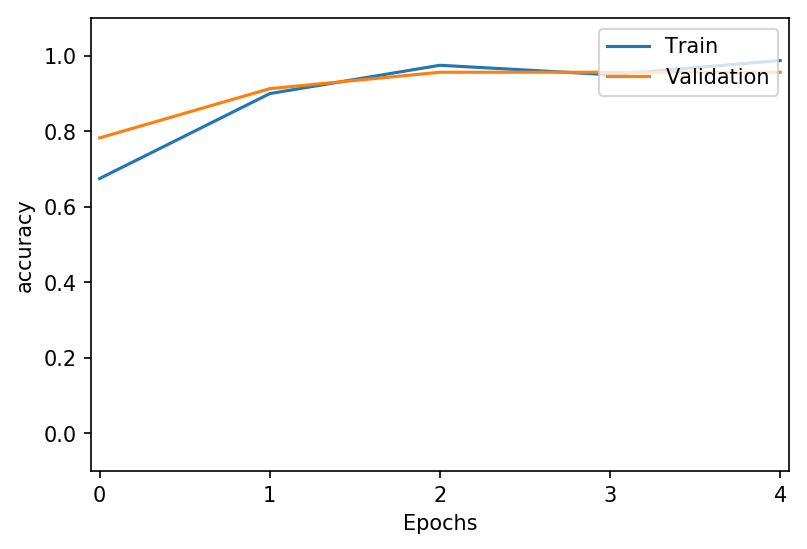

In [21]:
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)

Results on both the training and the validation sets are now much better. We expect this to have a positive impact on our search for similar images.

#### 3.B.b Model evaluation <a id="eval2"/>

As before, let's run our comparative set of images through the further trained model, extract their corresponding image embeddings, compute the distances to the reference image and rank the other images by distance to it.

In [22]:
# Save the features of the last batch normalization layer
featurizer = SaveFeatures(im_embedding) 

# Compute the predictions
for im_path in first_comparative_set_paths:
    learn.predict(open_image(str(im_path)))

# Extract the embeddings
features2 = featurizer.features

print(f"Updated embedding of our reference image:\n{features2[0,:]}")

Updated embedding of our reference image:
[ 0.001843 -0.467196 -0.163866 -0.335426 ...  0.49816  -0.061038  0.008149 -0.565123]


We can see that the embeddings of the test images have been updated with the better tuned model.

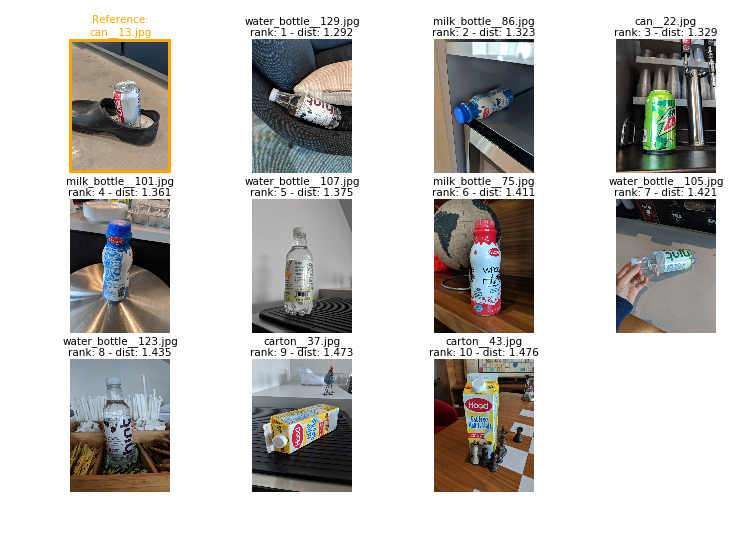

In [23]:
# Associate image path to image embedding
feature_dict2 = dict(zip(first_comparative_set_paths, features2))

# Compute distances and rank comparative images
similars2 = compute_topk_similar(first_ref_im_path, feature_dict2, distance=DISTANCE, top_k=TOP_K+1)

# Display the result
plot_similars(similars2, num_rows=3, num_cols=4)

Results are slightly better. Training on a bigger dataset, or changing the [dropout rate `ps`](https://docs.fast.ai/vision.learner.html#cnn_learner) or the learning rate may improve the outcome.

## 4. Performance metrics <a id="performance"/>

In the 2 cases we saw above, we assessed our results only visually. This is not sufficient. A numerical value would help us better quantify the "goodness" of our model and results.

For this, we will consider 2 metrics:
- Recall at k: Throughout all comparative sets, for how many of them were we able to get the positive example in the top k similar images?
- Median rank: Median rank of the positive example across all comparative sets.

As there is only one positive example in each comparative set, the concept of precision doesn't seem applicable. Indeed, to the question "out of the top k, how many were positive?", we could, at most, get a precision of 1/k. So, we focus on recall at k instead. Here, this translates to "did we find the positive example in what we predicted to be the top k similar images?". We also look at the median rank of the true positive image, throughout the comparative sets. Ideally, this median would be equal to 1, i.e. the positive image would be predicted as the closest to the reference.

So, let's run the predictions computation and image embedding extraction for all the comparative sets we created.

In [24]:
similarities_list = []
print(f"Processing:")
for reference_im_path in comparative_sets:
    print(f"--> {os.path.basename(reference_im_path)}")
    im_list = [str(im_path) for im_path in comparative_sets[reference_im_path]]
    comparative_set_paths = [reference_im_path] + im_list
    
    featurizer = SaveFeatures(im_embedding)

    # Compute the predictions
    for im_path in comparative_set_paths:
        learn.predict(open_image(str(im_path)))

    # Extract the embeddings
    features3 = featurizer.features
    
    # Associate image path to image embedding
    feature_dict3 = dict(zip(comparative_set_paths, features3))

    # Compute distances and rank comparative images
    dist_tuple_list = compute_topk_similar(reference_im_path, feature_dict3, distance=DISTANCE, top_k=len(comparative_set_paths))
    # Here, "top_k" = total number of images in the current comparative set, 
    # so we can get the rank of the positive image, even when it is > TOP_K
    
    # Append to the list of dist_tuple_list lists
    similarities_list.append(dist_tuple_list)

Processing:
--> can__13.jpg
--> can__19.jpg
--> can__22.jpg
--> can__24.jpg
--> carton__37.jpg
--> carton__43.jpg
--> carton__45.jpg
--> carton__47.jpg
--> milk_bottle__101.jpg
--> milk_bottle__71.jpg
--> milk_bottle__75.jpg
--> milk_bottle__86.jpg
--> water_bottle__105.jpg
--> water_bottle__107.jpg
--> water_bottle__123.jpg
--> water_bottle__129.jpg


Let's now compute the median rank of the positive example, and plot the distribution of ranks we obtained.

In [25]:
ranklist, medianrank = positive_image_median_rank(similarities_list)
print(f"The positive example ranks {medianrank}, as a median, across our {len(ranklist)} comparative sets")

The positive example ranks 1.0, as a median, across our 16 comparative sets


Text(0.5, 1.0, 'Distribution of positive example rank\nacross comparative sets')

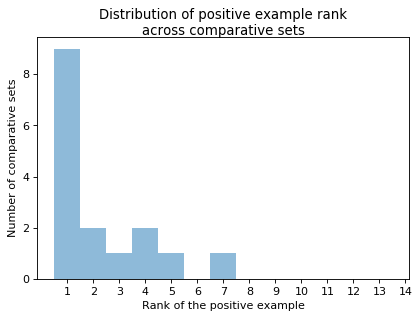

In [26]:
import matplotlib.pyplot as plt
plt.figure(dpi= 80)
bins = np.arange(1, len(first_comparative_set_paths)+1, 1) - 0.5
plt.hist(ranklist, bins=bins, alpha=0.5)
plt.xticks(bins+0.5)
plt.xlabel("Rank of the positive example")
plt.ylabel("Number of comparative sets")
plt.title("Distribution of positive example rank\nacross comparative sets")

In [27]:
print(f"The positive image is:\n --> {recall_at_k(ranklist, 10)}% of the time in the top 10 images\
      \n --> {recall_at_k(ranklist, 5)}% of the time in the top 5 images \
      \n --> {recall_at_k(ranklist, 1)}% of the time the most similar to the reference.")

The positive image is:
 --> 100.0% of the time in the top 10 images      
 --> 93.75% of the time in the top 5 images       
 --> 56.25% of the time the most similar to the reference.


## 5. Next steps <a id="next"/>

The best results for image similarity are typically obtained when the model trained is a siamese network or when it leverages triplet loss. This is what we will plan on sharing soon. In the meantime, we can try and train this model with a bigger dataset.

## Appendix <a id="appendix"/>

### A. Alternative visualization tool

With our `DistanceWidget`, we can display the results in a different fashion. Here we can interact with a user interface and navigate between the images of a comparative set, in distance order.

For this, we first need create a separate folder that contains these sorted images. We can then create a fast.ai's ImageDataBunch object, which we will use in our widget. In the example below, we leverage the images of our first comparative set and the results we stored in the `similars2` object.

In [28]:
# Create a separate folder
os.makedirs(os.path.join(image_root_folder, "comparative_set"), exist_ok=True)

for sim in similars2:
    idx = similars2.index(sim)
    # Extract the images' filenames
    im_name = os.path.basename(sim[0])
    # Copy the images in a sorted order, by adding an integer prefix to their names
    shutil.copy(sim[0], os.path.join(image_root_folder, "comparative_set", f"{str(idx).zfill(2)}_{im_name}"))
    # Compile these images into a fast.ai's ImageDataBunch object
    data2 = ImageDataBunch.from_folder(path,
                                       test=Path(image_root_folder)/"comparative_set",
                                       valid_pct=0.)

In [29]:
# Construct the *DistanceWidget* object by passing:
# - the test data from the *data2* object
# - the respective distances that are stored in the *similar2* object
w_results = DistanceWidget(
    dataset=data2.test_ds,
    distances=np.asarray([x[1] for x in similars2])
)

# Display the widget
display(w_results.show())

### B. Alternative way of retrieving the most similar images

In the example we presented here, the number N of images we had in our comparative sets was small (N=14). We could then afford to compute the distance between our reference and all the other images in each of our sets. In a real life scenario, however, the size of the comparative set may be very big, with thousands of images or more. Using brute force to search for the top k nearest neighbors then becomes inefficient. In that case, it is preferable to use an approximate method that is optimized for large (N) and high dimensional (D) datasets. A [Ball Tree](https://scikit-learn.org/stable/modules/neighbors.html#ball-tree) is a solution often considered, as its query time grows as [O\[Dlog(N)\]](https://scikit-learn.org/stable/modules/neighbors.html#choice-of-nearest-neighbors-algorithm), compared to O\[DN\] for brute force.

In the cells below, we demonstrate how to extract the TOP_K images using a Ball Tree, on the last of our comparative sets.

<i><b>Notes:</b></i>
- In our case, the number of image embeddings is &lt; 30, so the best method to use is the brute force, as we did initially.
- Other solutions, such as [locality sensitive hashing](https://towardsdatascience.com/locality-sensitive-hashing-for-music-search-f2f1940ace23) (LSH) are also popular to find nearest neighbors in large, high dimensionality datasets. This [library](https://pypi.org/project/LocalitySensitiveHashing/) is an example implementation in oython.

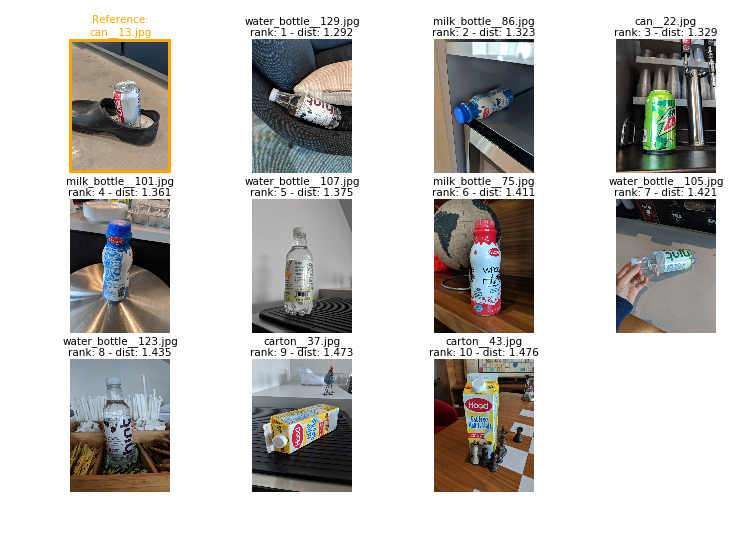

In [30]:
# Build the tree with all our image embeddings
normalized_features2 = features2 / np.linalg.norm(features2, axis=1).reshape(14,1)
btree = BallTree(normalized_features2, leaf_size=5, metric='euclidean')
# We normalized the embeddings, and chose "euclidean" to match our "L2" distance from above

# Query the tree for only the reference image
reference_im_embedding = np.reshape(normalized_features2[0,:], (-1, 512))
top_k_closest_im = btree.query(reference_im_embedding, k=TOP_K+1, return_distance=True)

# Notes:
# 1. We convert the reference image embedding into a 2D array so it has the same last dimension as the *features* object
# 2. We reduce *leaf_size* from 30 to 5 to force BallTree to execute as BallTree and not in the Brute Force mode
# 3. *btree.query()* returns a tuple of arrays: (array of distances, array of image indices), 
#    where each array is of shape (comparative set size, TOP_K+1)

# Sort the image paths in the order returned by the query to the Ball Tree
sorted_im_paths = itemgetter(*top_k_closest_im[1][0])(first_comparative_set_paths)
# Extract the associated distances
distances = top_k_closest_im[0][0]
# Build the list of (image path, distance to reference image) needed for our *plot_similars* function
similar_from_tree = [(im_path, dist) for im_path, dist in zip(sorted_im_paths, distances)]
# Display the results
plot_similars(similar_from_tree, num_rows=3, num_cols=4)

Depending on the comparative set, the results may be slightly different from those obtained using an exact nearest neighbors method.